<a href="https://colab.research.google.com/github/bharadwaj-vedula/Direct-Marketing-Optimisation/blob/main/Rebel_Foods_Modeling_MF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install Optuna

In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

In [76]:
import os
import pandas as pd
import numpy as np
from collections import Counter

import optuna

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold,RepeatedStratifiedKFold,cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report,f1_score,average_precision_score,roc_auc_score

# Paths

In [4]:
class config:
  path = '/content/drive/MyDrive/Rebel Foods Assignment/DataScientist_CaseStudy_Dataset  (1) (1).xlsx'

In [5]:
df_dem = pd.read_excel(config.path,sheet_name = 'Soc_Dem')
df_actBalance = pd.read_excel(config.path,sheet_name = 'Products_ActBalance')
df_inflowOutflow = pd.read_excel(config.path, sheet_name = 'Inflow_Outflow')
df_salesRevenue = pd.read_excel(config.path,sheet_name = 'Sales_Revenues')

# Mutual Fund Propensity Model

### Data Perp

1. NaNs can be filled with zero as most of them are realted to count and balances.



In [40]:
mf_clients = df_salesRevenue.loc[df_salesRevenue['Sale_MF'] == 1]['Client'].tolist()

In [41]:
df = df_dem.merge(df_actBalance, how= 'inner',on='Client').merge(df_inflowOutflow,how= 'inner',on='Client').merge(df_salesRevenue,how= 'inner',on='Client')


In [42]:
sexMapping = {'F':np.int16(0),'M':np.int16(1)}
df['Sex'] = df['Sex'].map(sexMapping)
df.fillna(0,inplace= True)

In [43]:
df.drop(columns = ['Sale_CC', 'Sale_CL','Revenue_MF', 'Revenue_CC', 'Revenue_CL'], inplace= True)

In [44]:
df.columns

Index(['Client', 'Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'Sale_MF'],
      dtype='object')

In [45]:
print(df['Sale_MF'].value_counts(dropna= False))
print(df_salesRevenue['Sale_MF'].value_counts(dropna= False))

Sale_MF
0    758
1    193
Name: count, dtype: int64
Sale_MF
0    776
1    193
Name: count, dtype: int64


# Feature Engineering (Test)

In [79]:
# 4.1. Interaction Features
df['ActBal_MF_x_Count_MF'] = df['ActBal_MF'] * df['Count_MF']
df['ActBal_MF_x_Tenure'] = df['ActBal_MF'] * df['Tenure']
df['Count_MF_x_Age'] = df['Count_MF'] * df['Age']
print("Added interaction features.")


# 4.2. Ratio Features (using a small epsilon to avoid division by zero)
EPSILON = 1e-6
df['VolumeCred_Ratio'] = df['VolumeCred'] / (df['VolumeDeb'] + EPSILON)
df['TransactionsCred_Ratio'] = df['TransactionsCred'] / (df['TransactionsDeb'] + EPSILON)
print("Added ratio features.")


# # 4.3. Account Presence Indicators (binary flags for non-MF/CA accounts)
# # Assuming 'Count_CA' is mostly 1 and 'Count_MF' is directly used.
# account_count_cols = ['Count_SA', 'Count_OVD', 'Count_CC', 'Count_CL']
# for col in account_count_cols:
#    df[f'Has_{col.replace("Count_", "")}'] = (df[col] > 0).astype(int)
# print("Added account presence indicators.")


# 4.4. Age Grouping
age_bins = [0, 25, 40, 55, 70, np.inf]
age_labels = ['lessthan_25', '25-40', '40-55', '55-70', '70+']
df['Age_Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)


# 4.5. Tenure Grouping (in months)
tenure_bins = [-1, 12, 60, 120, np.inf]
tenure_labels = ['lessthan_1Y', '1-5Y', '5-10Y', '10Y+']
df['Tenure_Group'] = pd.cut(df['Tenure'], bins=tenure_bins, labels=tenure_labels, right=False)


# 4.6. Credit/Debit Activity Summaries
df['Net_Volume_Transactions'] = df['VolumeCred'] - df['VolumeDeb']
df['Total_Transactions'] = df['TransactionsCred'] + df['TransactionsDeb']
# Sum of all actual balances (excluding MF as it's a direct feature)
balance_cols = [col for col in df.columns if 'ActBal_' in col and col != 'ActBal_MF']
df['Total_Other_ActBal'] = df[balance_cols].sum(axis=1)

#6. One-Hot Encode New Categorical Features ---
categorical_cols_to_encode = ['Age_Group', 'Tenure_Group']

# Perform One-Hot Encoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # sparse_output=False for dense array
encoded_features = encoder.fit_transform(df[categorical_cols_to_encode])
encoded_feature_names = encoder.get_feature_names_out(categorical_cols_to_encode)
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df.index)

# Drop original categorical columns and concatenate encoded ones
df = df.drop(columns=categorical_cols_to_encode)
df = pd.concat([df, encoded_df], axis=1)

Added interaction features.
Added ratio features.
Added Age_Group feature.
Added Tenure_Group feature.
Added credit/debit activity summaries and total other actual balances.


In [80]:
df

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,Total_Other_ActBal,Age_Group_25-40,Age_Group_40-55,Age_Group_55-70,Age_Group_70+,Age_Group_lessthan_25,Tenure_Group_1-5Y,Tenure_Group_10Y+,Tenure_Group_5-10Y,Tenure_Group_lessthan_1Y
0,1217,1.0,38,165,1,0.0,0.0,0.0,0.0,0.0,...,6.752245e+03,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,850,0.0,49,44,1,0.0,0.0,0.0,0.0,0.0,...,4.352321e+01,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1473,1.0,54,34,1,1.0,0.0,0.0,1.0,1.0,...,1.626333e+04,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1038,1.0,29,106,1,0.0,0.0,0.0,0.0,0.0,...,2.703571e+01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,225,1.0,14,187,1,0.0,0.0,1.0,0.0,0.0,...,9.640836e+02,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,621,0.0,37,152,1,1.0,0.0,0.0,0.0,0.0,...,1.249711e+03,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
947,1276,1.0,28,145,1,0.0,0.0,0.0,0.0,2.0,...,1.568051e+04,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
948,384,1.0,23,160,1,0.0,0.0,0.0,0.0,0.0,...,2.418877e+03,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
949,977,1.0,46,59,1,0.0,0.0,0.0,0.0,0.0,...,2.639309e+03,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Train Test Split

In [81]:
df_train , df_test = train_test_split( df, test_size= 0.2 , stratify = df['Sale_MF'])

In [82]:
df_train['Sale_MF'].value_counts()

,count
Sale_MF,
0,606
1,154


In [83]:
df_test['Sale_MF'].value_counts()

,count
Sale_MF,
0,152
1,39


In [84]:
cols = df_train.columns.tolist()

In [85]:
cols.remove('Sale_MF')

In [86]:
X = df_train.loc[:,cols]
y = df_train.loc[:,['Sale_MF']]

In [87]:
X

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,Total_Other_ActBal,Age_Group_25-40,Age_Group_40-55,Age_Group_55-70,Age_Group_70+,Age_Group_lessthan_25,Tenure_Group_1-5Y,Tenure_Group_10Y+,Tenure_Group_5-10Y,Tenure_Group_lessthan_1Y
98,1060,1.0,40,88,1,0.0,0.0,0.0,0.0,0.0,...,633.703929,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
421,160,0.0,41,181,1,0.0,0.0,0.0,0.0,0.0,...,3314.279643,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
636,418,1.0,28,8,1,0.0,0.0,0.0,0.0,0.0,...,435.667143,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17,1083,0.0,39,12,2,0.0,1.0,0.0,0.0,0.0,...,9911.578214,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
55,478,1.0,41,11,1,0.0,0.0,1.0,0.0,0.0,...,33573.151786,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,805,1.0,57,147,1,0.0,0.0,1.0,0.0,0.0,...,355.577500,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
558,1602,1.0,43,3,1,0.0,0.0,0.0,0.0,0.0,...,4380.475714,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
197,178,1.0,20,46,1,1.0,0.0,0.0,0.0,0.0,...,86.720714,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
379,1527,1.0,39,10,1,0.0,0.0,1.0,1.0,0.0,...,41.961429,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [88]:
y.value_counts()

,count
Sale_MF,
0,606
1,154


In [89]:
X_test = df_test.loc[:,cols]
y_test = df_test.loc[:,['Sale_MF']]

X_test.iloc[1]

,738
Client,593.000000
Sex,1.000000
Age,42.000000
Tenure,169.000000
Count_CA,1.000000
Count_SA,0.000000
Count_MF,0.000000
Count_OVD,0.000000
Count_CC,0.000000
Count_CL,0.000000


# XGBoost

In [ ]:
scores = {'f1_scores' : [], 'recall':[],'precision' : [],'accuracy':[],'auc_pr':[]}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2025)
for k,(train_idx, valid_idx) in enumerate(skf.split(X,y)):
  print(f'------------FOLD{k+1}------------')

  x_train = X.iloc[train_idx,1:].values
  y_train = y.iloc[train_idx].values

  x_valid = X.iloc[valid_idx,1:].values
  y_valid = y.iloc[valid_idx].values

  counter = Counter(y_train)
  weight = counter[0]/counter[1]

  # print(weight)

  clf = XGBClassifier()
  clf.fit(x_train,y_train)
  y_pred = clf.predict(x_valid)


  print(f'Accuracy score {accuracy_score(y_valid,y_pred)}')
  print(f'Recall score {recall_score(y_valid,y_pred)}')
  print(f'Precision score { precision_score(y_valid,y_pred)}')
  print(f'F1 score {f1_score(y_valid,y_pred)}')
  print(f'AUC PR {average_precision_score(y_valid,y_pred)}')
  print(f'Classification Report \n {classification_report(y_valid,y_pred)}')

  scores['f1_scores'].append(f1_score(y_valid,y_pred))
  scores['recall'].append(recall_score(y_valid,y_pred))
  scores['precision'].append(precision_score(y_valid,y_pred))
  scores['accuracy'].append(accuracy_score(y_valid,y_pred))
  scores['auc_pr'].append(average_precision_score(y_valid,y_pred))




In [42]:
print(f'Mean F1 Scores {np.mean(scores["f1_scores"])}')
print(f'Mean Precision {np.mean(scores["precision"])}')
print(f'Mean Recall {np.mean(scores["recall"])}')
print(f'Mean AUC PR {np.mean(scores["auc_pr"])}')

Mean F1 Scores 0.20069449155335078
Mean Precision 0.3766666666666667
Mean Recall 0.14258064516129032
Mean AUC PR 0.23118958687040184


# Hyper parameter tuning

In [90]:
def objective(trial):
    """
    Objective function for Optuna to optimize.
    It trains an XGBoost Classifier with suggested hyperparameters and returns the
    cross-validated ROC AUC score.
    """
    param = {
        # 'objective': 'binary:logistic',
        'eval_metric': 'aucpr', # Use AUCPR for evaluation during training, good for imbalance
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']), # Try different boosters
        'tree_method': 'hist', # Faster for large datasets
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000), # Number of boosting rounds
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-2, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 0.5, log=True),
        'lambda': trial.suggest_float('lambda', 1e-8, 100.0, log=True), # L2 regularization
        'alpha': trial.suggest_float('alpha', 1e-8, 100.0, log=True), # L1 regularization
        'use_label_encoder': False, # Suppress warning for older versions
        'random_state': 2025,
        'n_jobs': -1, # Use all available cores
        'early_stopping_rounds' : 50,

        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.6, 1.0)
    }

    if param['booster'] == 'dart':
        param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        param['rate_drop'] = trial.suggest_float('rate_drop', 0.0, 0.5)
        param['skip_drop'] = trial.suggest_float('skip_drop', 0.0, 0.5)

    param['scale_pos_weight'] = trial.suggest_float(
        'scale_pos_weight',
        3.5 * 0.5,
        3.5 * 1.5,
        log=True
    )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2025)
    roc_auc_scores = []

    for train_index, val_index in skf.split(X, y):
        X_train_fold, X_val_fold = X.iloc[train_index,1:].values, X.iloc[val_index,1:].values
        y_train_fold, y_val_fold = y.iloc[train_index].values, y.iloc[val_index].values

        model = XGBClassifier(**param)

        model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_val_fold, y_val_fold)],
                  verbose=False)

        val_preds_proba = model.predict(X_val_fold)

        if len(np.unique(y_val_fold)) == 2:
            f1 = f1_score(y_val_fold, val_preds_proba)
            roc_auc_scores.append(f1)
        else:
            continue

    if len(roc_auc_scores) > 0:
        return np.mean(roc_auc_scores)
    else:
        return 0.0


In [ ]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=2025))
print("Starting Optuna hyperparameter tuning...")
study.optimize(objective, n_trials=50, show_progress_bar=True)
print("Optuna tuning complete.")


In [92]:
print("\nBest trial:")
trial = study.best_trial

print(f"  Value (Mean CV F1 Score): {trial.value:.4f}")
print("  Best Parameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")



Best trial:
  Value (Mean CV F1 Score): 0.4050
  Best Parameters:
    booster: gbtree
    n_estimators: 149
    learning_rate: 0.09452058317678926
    max_depth: 4
    subsample: 0.8221032027819011
    colsample_bytree: 0.8939196956669244
    min_child_weight: 4.168720622038463
    gamma: 0.0005445653216235619
    lambda: 0.0025501459962714787
    alpha: 5.925863592354545e-07
    colsample_bylevel: 0.6182320021533182
    colsample_bynode: 0.7111969263520991
    scale_pos_weight: 4.592026721453263


In [93]:
# Train the final model with the best parameters on the full training data
best_params = trial.params
final_model = XGBClassifier(**best_params, use_label_encoder=False,
                                 eval_metric='aucpr',
                                 random_state=2025,
                                  n_jobs=-1,
                                  early_stopping_rounds = 50

                            )

print("\nTraining final model with best parameters...")
final_model.fit(X, y,
                eval_set=[(X_test, y_test)],
                verbose=True)



Training final model with best parameters...
[0]	validation_0-aucpr:0.19015
[1]	validation_0-aucpr:0.20440
[2]	validation_0-aucpr:0.21205
[3]	validation_0-aucpr:0.20662
[4]	validation_0-aucpr:0.20559
[5]	validation_0-aucpr:0.21968
[6]	validation_0-aucpr:0.22488
[7]	validation_0-aucpr:0.25181
[8]	validation_0-aucpr:0.23614
[9]	validation_0-aucpr:0.22439
[10]	validation_0-aucpr:0.20932
[11]	validation_0-aucpr:0.20927
[12]	validation_0-aucpr:0.21031
[13]	validation_0-aucpr:0.20677
[14]	validation_0-aucpr:0.21303
[15]	validation_0-aucpr:0.21223
[16]	validation_0-aucpr:0.20696
[17]	validation_0-aucpr:0.20654
[18]	validation_0-aucpr:0.20844
[19]	validation_0-aucpr:0.21588
[20]	validation_0-aucpr:0.20256
[21]	validation_0-aucpr:0.20451
[22]	validation_0-aucpr:0.20430
[23]	validation_0-aucpr:0.20575
[24]	validation_0-aucpr:0.20229
[25]	validation_0-aucpr:0.20305
[26]	validation_0-aucpr:0.20172
[27]	validation_0-aucpr:0.20097
[28]	validation_0-aucpr:0.20544
[29]	validation_0-aucpr:0.20785
[30]

XGBClassifier(alpha=5.925863592354545e-07, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=0.6182320021533182,
              colsample_bynode=0.7111969263520991,
              colsample_bytree=0.8939196956669244, device=None,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric='aucpr', feature_types=None,
              gamma=0.0005445653216235619, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=0.0025501459962714787, learning_rate=0.09452058317678926,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=4.168720622038463, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=149,
              n_jobs=-1, ...)

In [94]:
print("\nEvaluating final model on test set:")

y_pred_proba = final_model.predict(X_test)
y_pred_class = (y_pred_proba > 0.5).astype(int) # Default threshold of 0.5

# ROC AUC
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC AUC: {test_roc_auc:.4f}")

# Precision, Recall, F1-Score
test_precision = precision_score(y_test, y_pred_class)
test_recall = recall_score(y_test, y_pred_class)
test_f1 = f1_score(y_test, y_pred_class)

print(f"Test Precision (at 0.5 threshold): {test_precision:.4f}")
print(f"Test Recall (at 0.5 threshold): {test_recall:.4f}")
print(f"Test F1-Score (at 0.5 threshold): {test_f1:.4f}")


Evaluating final model on test set:
Test ROC AUC: 0.5024
Test Precision (at 0.5 threshold): 0.2056
Test Recall (at 0.5 threshold): 0.5641
Test F1-Score (at 0.5 threshold): 0.3014


In [ ]:

# Evaluating final model on test set:
# Test ROC AUC: 0.5348
# Test Precision (at 0.5 threshold): 0.2414
# Test Recall (at 0.5 threshold): 0.3590
# Test F1-Score (at 0.5 threshold): 0.2887

# Saving Model

In [24]:
final_model.save_model('/content/drive/MyDrive/Rebel Foods Assignment/Models/XGBClassifier_MF.json')

Feature importances extracted and sorted.

Top 10 features by importance:
Count_CC                        0.071493
Count_OVD                       0.056101
Count_MF                        0.051612
TransactionsDebCashless_Card    0.049639
ActBal_CC                       0.047547
Sex                             0.047200
VolumeCred_CA                   0.042769
ActBal_CL                       0.040375
ActBal_MF                       0.039678
ActBal_SA                       0.039611
dtype: float32

Generating feature importance plot...


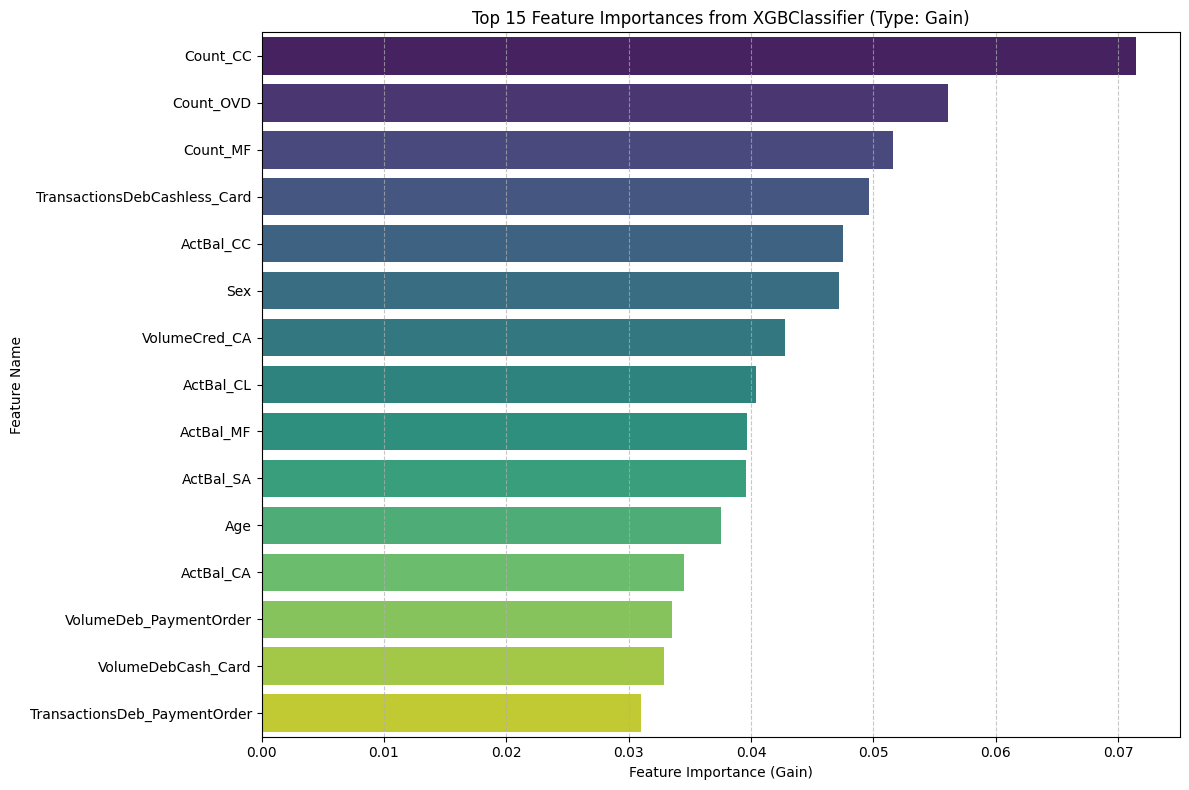


Feature importance plot displayed. You can save it using plt.savefig('feature_importance.png') if needed.


In [25]:
feature_importances = final_model.feature_importances_

importance_series = pd.Series(feature_importances, index=X.columns)

sorted_importance = importance_series.sort_values(ascending=False)

print("Feature importances extracted and sorted.")
print("\nTop 10 features by importance:")
print(sorted_importance.head(10))


num_features_to_plot = 15
top_features_to_plot = sorted_importance.head(num_features_to_plot)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_features_to_plot.values, y=top_features_to_plot.index, palette='viridis')

plt.title(f'Top {num_features_to_plot} Feature Importances from XGBClassifier (Type: Gain)')
plt.xlabel('Feature Importance (Gain)')
plt.ylabel('Feature Name')
plt.grid(axis='x', linestyle='--', alpha=0.7) # Add horizontal grid lines
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

print("\nFeature importance plot displayed. You can save it using plt.savefig('feature_importance.png') if needed.")